In [218]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
sns.set() 

# Read data
df = pd.read_csv("spotify-2023.csv", encoding='ISO-8859-1')

# Print first 5 rows
df.head(5)

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


# Dealing with Null/Missing Values #

In [219]:
# Checking for null values in "in_shazam_charts" column
print(df['in_shazam_charts'].isnull().sum())

# drop shazam charts because of missing values / unnecessary for our analysis
df = df.drop(columns=['in_shazam_charts'], axis=1)

50


In [220]:
# find the missing values in the dataset in the key column
missing_values_sum = df['key'].isna().sum()
print(missing_values_sum)

# change NaN values to "Multiple Keys"
df['key'] = df['key'].fillna('Multiple Keys')

print(df['key'].value_counts(dropna=False))

95
C#               120
G                 96
Multiple Keys     95
G#                91
F                 89
B                 81
D                 81
A                 75
F#                73
E                 62
A#                57
D#                33
Name: key, dtype: int64


# Dealing With DataTypes #

In [221]:
# Check the datatypes and change if necessary
print(df.dtypes)

## Check for invalid Stream Values. 
for stream in df['streams']:
    try:
        int(stream)
    except ValueError:
        print(stream + ' is not an integer Value')

# delete line 576 row of the csv file because the streams value is a misinput, and without the actual streams count we can't impute
df = df[df['streams'] != 'BPM110KeyAModeMajorDanceability53Valence75Energy69Acousticness7Instrumentalness0Liveness17Speechiness3']
df['streams'] = df['streams'].apply(int)

track_name              object
artist(s)_name          object
artist_count             int64
released_year            int64
released_month           int64
released_day             int64
in_spotify_playlists     int64
in_spotify_charts        int64
streams                 object
in_apple_playlists       int64
in_apple_charts          int64
in_deezer_playlists     object
in_deezer_charts         int64
bpm                      int64
key                     object
mode                    object
danceability_%           int64
valence_%                int64
energy_%                 int64
acousticness_%           int64
instrumentalness_%       int64
liveness_%               int64
speechiness_%            int64
dtype: object
BPM110KeyAModeMajorDanceability53Valence75Energy69Acousticness7Instrumentalness0Liveness17Speechiness3 is not an integer Value


In [222]:
## Check for invalid Stream Values. 
invalid_streams = []
for stream in df['in_deezer_playlists']:
    try:
        int(stream)
    except ValueError:
        invalid_streams.append(stream)

# Check to see if there are any strings that we cannot convert to integers
print(len(invalid_streams))

# Print the first 5 elements of the array to see what the strings look like
print(invalid_streams[:5])

# Remove all commas in the strings (2,445 -> 2445) so we can cast to ints
df['in_deezer_playlists'].replace(',','', regex=True, inplace=True)

## Check for invalid Stream Values Again. 
invalid_streams = []
for stream in df['in_deezer_playlists']:
    try:
        int(stream)
    except ValueError:
        invalid_streams.append(stream)

# Check to see if there are any more invalid strings that we cannot convert to integers
print(len(invalid_streams))
df['in_deezer_playlists'] = df['in_deezer_playlists'].apply(int)



79
['2,445', '3,394', '3,421', '4,053', '1,056']
0


In [223]:
# # Define a function that converts a string into a set of artists rather than array or single string
# def get_artist_names(artist_string):
#     if (type(artist_string) == str):
#         return {artist_string}
#     elif (type(artist_string) == list):
#         return set(artist_string)

# # Apply the function to the artist(s)_name column
# df['artist(s)_name'] = df['artist(s)_name'].apply(get_artist_names)

# # print head to inspect the data
# df.head(5)

In [224]:
df_sorted = df.sort_values('streams', ascending=False)


df_sorted['label'] = 0
df_sorted.iloc[:200, df_sorted.columns.get_loc('label')] = 1
df_sorted.iloc[200:400, df_sorted.columns.get_loc('label')] = 2
df_sorted.iloc[400::, df_sorted.columns.get_loc('label')] = 3


df = df_sorted

df.head(5)

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,label
55,Blinding Lights,The Weeknd,1,2019,11,29,43899,69,3703895074,672,...,C#,Major,50,38,80,0,0,9,7,1
179,Shape of You,Ed Sheeran,1,2017,1,6,32181,10,3562543890,33,...,C#,Minor,83,93,65,58,0,9,8,1
86,Someone You Loved,Lewis Capaldi,1,2018,11,8,17836,53,2887241814,440,...,C#,Major,50,45,41,75,0,11,3,1
620,Dance Monkey,Tones and I,1,2019,5,10,24529,0,2864791672,533,...,F#,Minor,82,54,59,69,0,18,10,1
41,Sunflower - Spider-Man: Into the Spider-Verse,"Post Malone, Swae Lee",2,2018,10,9,24094,78,2808096550,372,...,D,Major,76,91,50,54,0,7,5,1


In [225]:
# knn nearest neighbor algorithm implementation

SEED = 7

df = pd.get_dummies(df, drop_first=True) #drop one of the encoded gender columns
df.head()

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,...,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,key_Multiple Keys,mode_Minor
55,1,2019,11,29,43899,69,3703895074,672,199,3421,...,1,0,0,0,0,0,0,0,0,0
179,1,2017,1,6,32181,10,3562543890,33,0,6808,...,1,0,0,0,0,0,0,0,0,1
86,1,2018,11,8,17836,53,2887241814,440,125,1800,...,1,0,0,0,0,0,0,0,0,0
620,1,2019,5,10,24529,0,2864791672,533,167,3595,...,0,0,0,0,0,1,0,0,0,1
41,2,2018,10,9,24094,78,2808096550,372,117,843,...,0,1,0,0,0,0,0,0,0,0


# Preliminary Modeling Efforts #

<Axes: >

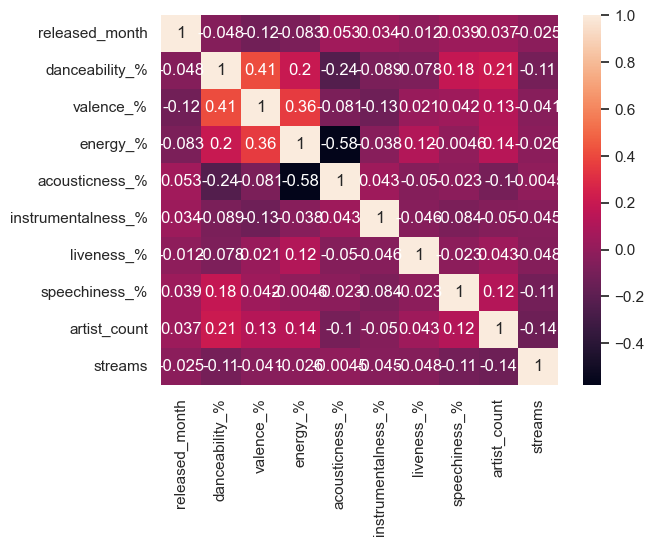

In [233]:
# Create a correlation matrix of the features
sns.heatmap(df[['released_month', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%' , 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'artist_count', 'streams']].corr(), annot=True)

Through the Correlation Matrix we can see that none of the features have a clear correlation with the number of streams that a song gets. Of the features we can see that speechiness, daceability, and artist count have the highest correlation but still very low.

## Decision Tree Classifier ##

In [226]:
# decision tree classifier
from sklearn.tree import DecisionTreeClassifier
#encode the categorical feature


X   = df[['released_month', 'mode_Minor', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%' , 'instrumentalness_%', 'liveness_%', 'speechiness_%']] #get the input features
y   = df['label']              #get the target

X_train, X_test, y_train, y_test = train_test_split(X,              #the input features
                                                    y,              #the label
                                                    test_size=0.3,  #set aside 30% of the data as the test set
                                                    random_state=SEED,                             
                                                    stratify=y      #preserve the distribution of the labels
                                                   )

# change the criterion value for decision tree classifier

accuracy_scores = []

for i in range(2, 20, 2):
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=SEED)
    dt.fit(X_train, y_train)

    #predict the labels for the test set
    y_pred   = dt.predict(X_test)

    #get the classification report for the decision tree
    y_pred = dt.predict(X_test)

    accuracy_scores.append(dt.score(X_test, y_test))

print(accuracy_scores)
    


[0.5804195804195804, 0.5104895104895105, 0.527972027972028, 0.5244755244755245, 0.486013986013986, 0.46153846153846156, 0.4160839160839161, 0.42657342657342656, 0.44755244755244755]


## Findings ##

We found that a max_depth of 2 had the best accuracy score of ~58%.

## Random Forest Classification ##

In [237]:
# random forest classification

df = pd.get_dummies(df, drop_first=True) #drop one of the encoded gender colum

# Input features
X   = df[['released_month', 'mode_Minor', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%' , 'bpm', 'liveness_%', 'speechiness_%']] #get the input features
y   = df['label']              #get the target

# Split the test data
X_train, X_test, y_train, y_test = train_test_split(X,              #the input features
                                                    y,              #the label
                                                    test_size=0.3,  #set aside 30% of the data as the test set
                                                    random_state=SEED, #reproduce the results
                                                    stratify=y      #preserve the distribution of the labels
                                                   )

# Create a list for holding the accuracy scores
accuracy_scores = []

for i in range(10, 120, 10):
    rf = RandomForestClassifier(criterion='entropy', n_estimators = i, random_state = SEED)
    rf.fit(X_train, y_train)

    #predict the labels for the test set
    y_pred   = rf.predict(X_test)

    #get the classification report for the decision tree
    y_pred = rf.predict(X_test)

    accuracy_scores.append(rf.score(X_test, y_test))


print(accuracy_scores)

# 
best_model = RandomForestClassifier(criterion='entropy', n_estimators = 90, random_state = SEED)

best_model.fit(X_train, y_train)

important_features = best_model.feature_importances_
features_names = X_test.columns
feature_importance_df = pd.DataFrame({'Feature': features_names, 'Importance': important_features})
# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).round(2)

print(feature_importance_df.head(20))



[0.5034965034965035, 0.534965034965035, 0.5174825174825175, 0.5524475524475524, 0.5559440559440559, 0.5559440559440559, 0.5559440559440559, 0.5524475524475524, 0.5629370629370629, 0.5594405594405595, 0.5559440559440559]
          Feature  Importance
6             bpm        0.14
3       valence_%        0.13
2  danceability_%        0.13
5  acousticness_%        0.13
4        energy_%        0.12
7      liveness_%        0.11
0  released_month        0.10
8   speechiness_%        0.10
1      mode_Minor        0.03


## Findings ##

With 90 estimators we were able to acquire an accuracy score of ~56%. 

## Support Vector Machines ##

In [229]:
X   = df[['released_month', 'mode_Minor', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%' , 'bpm', 'liveness_%', 'speechiness_%', 'in_spotify_playlists']] #get the input features
y   = df['label']              #get the target

X_train, X_test, y_train, y_test = train_test_split(X,              #the input features
                                                    y,              #the label
                                                    test_size=0.3,  #set aside 30% of the data as the test set
                                                    random_state=SEED, #reproduce the results
                                                    stratify=y      #preserve the distribution of the labels
                                                   )

X_train = X_train.copy()
X_test  = X_test.copy()

#encode the categorical feature
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore') #drop one of the encoded gender columns
encoder.fit(X_train[['mode_Minor']])
#enc.categories_ #view the categories

X_train['mode_Minor'] = encoder.transform(X_train[['mode_Minor']])

scaler = StandardScaler()
scaler.fit(X_train[['released_month', 'mode_Minor', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%' , 'bpm', 'liveness_%', 'speechiness_%', 'in_spotify_playlists']])

X_train[['released_month', 'mode_Minor', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%' , 'bpm', 'liveness_%', 'speechiness_%', 'in_spotify_playlists']] = scaler.transform(X_train[['released_month', 'mode_Minor', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%' , 'bpm', 'liveness_%', 'speechiness_%', 'in_spotify_playlists']]) #scale the training data

#initialize the classifier

params = {'C': np.arange(1, 10),
         'gamma': np.arange(1, 5)}

svm = SVC() #the default kernel is rbf

#initialize Grid Search with Cross Validation
svm_grid = GridSearchCV(estimator = svm, param_grid = params, cv=5)
svm_grid.fit(X_train, y_train)

print(svm_grid.best_params_) #print the best parameters
print(svm_grid.best_score_)  #print the best score



C:\Users\uzayt\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


{'C': 3, 'gamma': 1}
0.5915946582875098


## Findings ##

With a C value of 3 and a gamma value of 1 we were able to achieve a 59% accuracy. 